In [11]:
# Dependencies
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

from pprint import pprint
import gmaps
import matplotlib.pyplot as plt

In [ ]:
# Import google API key
from config import gmaps_key

In [12]:
# Combine raw data into a data frame
yrs_15to18_path = os.path.join("data","crash_data_2015-2018.csv")
yrs_19to21_path = os.path.join("data","crash_data_2019-2021.csv")
years_15to18 = pd.read_csv(yrs_15to18_path)
years_19to21 = pd.read_csv(yrs_19to21_path)
crash_df = pd.concat([years_19to21,years_15to18],ignore_index=True)
crash_df

,CRASH_DATE,CRASH_TIME,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_DIRECTION,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,LATITUDE,LONGITUDE
0,1/7/2021,3:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,UNABLE TO DETERMINE,W,3,NO INDICATION OF INJURY,0.0,0.0,3,41.924260,-87.753029
1,1/7/2021,0:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,UNABLE TO DETERMINE,N,2,NONINCAPACITATING INJURY,1.0,0.0,0,41.902701,-87.711526
2,1/7/2021,0:26,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,...,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,N,3,NO INDICATION OF INJURY,0.0,0.0,0,41.935010,-87.756408
3,1/7/2021,0:07,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,NOT APPLICABLE,S,1,NONINCAPACITATING INJURY,2.0,0.0,0,41.838327,-87.617613
4,1/6/2021,23:21,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,NOT APPLICABLE,W,2,NO INDICATION OF INJURY,0.0,0.0,23,41.881926,-87.745462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467652,8/4/2015,8:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,DISREGARDING TRAFFIC SIGNALS,S,2,"REPORTED, NOT EVIDENT",1.0,0.0,8,41.816471,-87.621551
467653,8/4/2015,5:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,NOT APPLICABLE,N,2,NO INDICATION OF INJURY,0.0,0.0,5,41.881057,-87.771673
467654,8/3/2015,18:37,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,...,FOLLOWING TOO CLOSELY,UNABLE TO DETERMINE,N,2,NO INDICATION OF INJURY,0.0,0.0,18,41.896980,-87.656687
467655,8/3/2015,15:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,"EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",FOLLOWING TOO CLOSELY,N,2,NO INDICATION OF INJURY,0.0,0.0,15,41.912188,-87.680491


In [9]:
crash_columns = crash_df.columns
print(crash_columns)

Index(['CRASH_DATE', 'CRASH_TIME', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION',
       'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'CRASH_HOUR', 'LATITUDE', 'LONGITUDE'],
      dtype='object')


In [14]:
# Setup Google Maps API
# gmaps.configure(api_key=gmaps_key)

#### What impacts crash type the most? - Romi

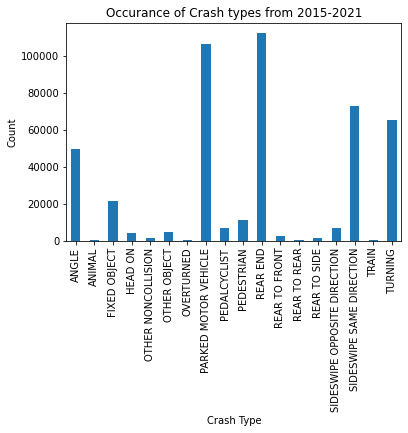

<Figure size 432x288 with 0 Axes>

In [15]:
# Create first crash type bar graph
grouped_crahses = crash_df.groupby(["FIRST_CRASH_TYPE"])
crash_count = grouped_crahses["FIRST_CRASH_TYPE"].count()
crash_chart = crash_count.plot(kind='bar')
crash_chart.set_xlabel("Crash Type")
crash_chart.set_ylabel("Count")
crash_chart.set_title("Occurance of Crash types from 2015-2021")
plt.show()
plt.tight_layout()

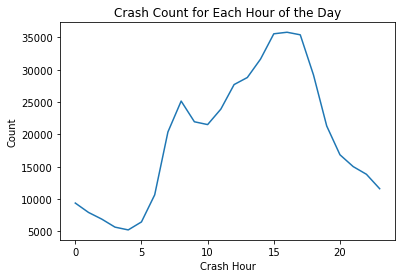

<Figure size 432x288 with 0 Axes>

In [16]:
# Create crash count per hour (histogram/line)
crahses_per_hour_grouped = crash_df.groupby(["CRASH_HOUR"])
hour_count = crahses_per_hour_grouped["CRASH_HOUR"].count()
hour_chart = hour_count.plot(kind='line')
hour_chart.set_xlabel("Crash Hour")
hour_chart.set_ylabel("Count")
hour_chart.set_title("Crash Count for Each Hour of the Day")
plt.show()
plt.tight_layout()

In [17]:
crahses_per_hour_grouped = crash_df.groupby(["CRASH_HOUR"])
hour_count = crahses_per_hour_grouped["CRASH_HOUR"].count()
hour_chart = hour_count.plot(kind='bar')
hour_chart.set_xlabel("Crash Hour")
hour_chart.set_ylabel("Count")
hour_chart.set_title("Crash Count for Each Hour of the Day")
plt.show()
plt.tight_layout()

In [18]:
crash_df.head()

,CRASH_DATE,CRASH_TIME,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_DIRECTION,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,LATITUDE,LONGITUDE
0,1/7/2021,3:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,UNABLE TO DETERMINE,W,3,NO INDICATION OF INJURY,0.0,0.0,3,41.924260,-87.753029
1,1/7/2021,0:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,UNABLE TO DETERMINE,N,2,NONINCAPACITATING INJURY,1.0,0.0,0,41.902701,-87.711526
2,1/7/2021,0:26,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,...,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,N,3,NO INDICATION OF INJURY,0.0,0.0,0,41.935010,-87.756408
3,1/7/2021,0:07,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,NOT APPLICABLE,S,1,NONINCAPACITATING INJURY,2.0,0.0,0,41.838327,-87.617613
4,1/6/2021,23:21,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,NOT APPLICABLE,W,2,NO INDICATION OF INJURY,0.0,0.0,23,41.881926,-87.745462


In [75]:
new_crash_df = crash_df
new_crash_df['Month'] = pd.DatetimeIndex(new_crash_df['CRASH_DATE']).month
new_crash_df.head()

,CRASH_DATE,CRASH_TIME,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,SEC_CONTRIBUTORY_CAUSE,STREET_DIRECTION,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,LATITUDE,LONGITUDE,Month
0,1/7/2021,3:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,W,3,NO INDICATION OF INJURY,0.0,0.0,3,41.924260,-87.753029,1
1,1/7/2021,0:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,N,2,NONINCAPACITATING INJURY,1.0,0.0,0,41.902701,-87.711526,1
2,1/7/2021,0:26,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,...,NOT APPLICABLE,N,3,NO INDICATION OF INJURY,0.0,0.0,0,41.935010,-87.756408,1
3,1/7/2021,0:07,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,NOT APPLICABLE,S,1,NONINCAPACITATING INJURY,2.0,0.0,0,41.838327,-87.617613,1
4,1/6/2021,23:21,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,NOT APPLICABLE,W,2,NO INDICATION OF INJURY,0.0,0.0,23,41.881926,-87.745462,1


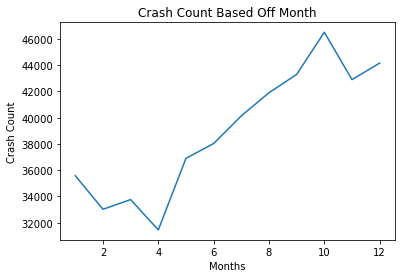

<Figure size 432x288 with 0 Axes>

In [77]:
# Create hit and run vs month (line) -analysis correlation to holidays
month_grouped = new_crash_df.groupby(["Month"])
month_count = month_grouped["Month"].count()
month_chart = month_count.plot(kind='line')
month_chart.set_xlabel("Months")
month_chart.set_ylabel("Crash Count")
month_chart.set_title("Crash Count Based Off Month")
plt.show()
plt.tight_layout()

#### What type of injuries are caused by what types of crashes? - Jonathan

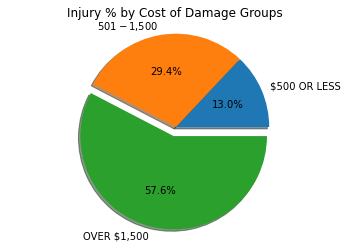

In [67]:
# Create cost of damage and injury count (pie chart)
damage_group = crash_df.groupby("DAMAGE")
injury_count = damage_group["INJURIES_TOTAL"].count()
damage_inj_df = pd.DataFrame(injury_count)                            

#damage_inj_df

labels = list(damage_inj_df.index.values)
injuries = damage_inj_df["INJURIES_TOTAL"]
explode = (0,0,0.1)
#print(damage_inj_df.index)

plt.pie(injuries, labels=labels, autopct="%1.1f%%", shadow=True, explode=explode)
plt.title("Injury % by Cost of Damage Groups")
plt.axis('equal')
#plt.xlabel("Cost of Damage")
#plt.ylabel("Injury Count")

plt.savefig("output_data/injuries_by_cost_of_damage_group.png")

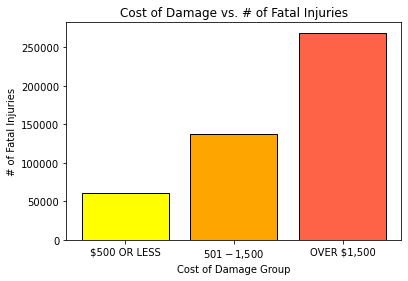

In [81]:
# Create cost of damage and fatal injury count (scatter with regression)
fatal_count = damage_group["INJURIES_FATAL"].count()
damages_fatal_df = pd.DataFrame(fatal_count)

#print(damages_fatal_df)
x_labels = list(damage_inj_df.index.values)
y_values = fatal_count

plt.bar(x_labels, y_values, color=["yellow", "orange", "tomato"], edgecolor="black")
plt.title("Cost of Damage vs. # of Fatal Injuries")
plt.xlabel("Cost of Damage Group")
plt.ylabel("# of Fatal Injuries")

plt.savefig("output_data/cost_of_damage_vs_fatalities.png")

In [21]:
# Create speed vs. fatality count (scatter with regression)

#### What types of wrecks occur based off location? - Andrew

In [22]:
# Create bar graph for trafficway_type

In [23]:
# Create heat map for total injuries by location

In [24]:
# Create heat map for fatal injuries by location

Create heat map of crashes by location with location of high schools plotted

In [25]:
# get center coordinates of data
crash_with_locdata = crash_df.loc[crash_df["LATITUDE"] >=41, :]
crash_with_locdata = crash_with_locdata.loc[crash_df["LATITUDE"] <=43, :]
crash_with_locdata = crash_with_locdata.loc[crash_df["LONGITUDE"] >= -88, :]
crash_with_locdata = crash_with_locdata.loc[crash_df["LONGITUDE"] <= -86, :]
center = f"{crash_with_locdata['LATITUDE'].mean()},{crash_with_locdata['LONGITUDE'].mean()}"

In [26]:
# call google api for high schools within 30000 meters (~18 miles)
base_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
params = {
    "key": gmaps_key,
    "query": "high school",
    "location": center,
    "radius": "30000"
}
response = requests.get(base_url,params=params).json()

In [27]:
# store high school data
results = response["results"]
schools_df = pd.DataFrame({})
schools_df["name"] = [results[i]["name"] for i in range(len(results))]
schools_df["lat"] = [results[i]["geometry"]["location"]["lat"] for i in range(len(results))]
schools_df["lng"] = [results[i]["geometry"]["location"]["lng"] for i in range(len(results))]
schools_df["address"] = [results[i]["formatted_address"][:-len(", United States")] for i in range(len(results))]

In [28]:
# Create heat map of crashes by location with location of high schools plotted
fig = gmaps.figure()
school_coordinates = schools_df[["lat","lng"]].astype(float)
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>Address</dt><dd>{address}</dd>
</dl>
"""
school_info = [info_box_template.format(**row) for index, row in schools_df.iterrows()]
markers = gmaps.marker_layer(school_coordinates, info_box_content=school_info)
fig.add_layer(markers)

In [29]:
# generate heat map of crashes
#crash_coordinates = crash_with_locdata[["LATITUDE","LONGITUDE"]].astype(float)
#heat_layer = gmaps.heatmap_layer(crash_coordinates, dissipating=False, max_intensity=1, point_radius=1)
#fig.add_layer(heat_layer)

In [30]:
fig

Figure(layout=FigureLayout(height='420px'))

#### What weird connections can we make?

In [ ]:
#Baker
# Create direction facing bar graph (NSEW)

In [ ]:
# Andrew
# Pull in dataset for moon phases
# Create crash count vs. moon phases